In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import h5py
import os

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Path to the dataset file
data_path = '../data/quark-gluon_data-set_n139306.hdf5'  # Adjust path if needed

def load_dataset():
    """Load the quark/gluon dataset"""
    with h5py.File(data_path, 'r') as f:
        X_jets_full = f['X_jets'][:]
        y = f['y'][:]
    
    print(f"X_jets shape: {X_jets_full.shape}")
    print(f"y shape: {y.shape}")
    print(f"y distribution: {np.unique(y, return_counts=True)}")
    
    return X_jets_full, y

def image_to_point_cloud(image, min_value=0):
    """Convert a 3-channel image to a point cloud by extracting non-zero pixels"""
    height, width, channels = image.shape
    
    # Find non-zero pixels (any channel)
    mask = np.any(image > min_value, axis=2)
    y_indices, x_indices = np.where(mask)
    
    # Get the values at those positions
    points = []
    features = []
    
    for y, x in zip(y_indices, x_indices):
        points.append([x, y])  # Store as (x, y) for consistency
        features.append(image[y, x, :])
    
    if len(points) == 0:
        # If no non-zero pixels, return a single zero point at the center
        return {
            'positions': np.array([[width // 2, height // 2]]),
            'features': np.zeros((1, channels)),
            'num_points': 1
        }
    
    return {
        'positions': np.array(points),
        'features': np.array(features),
        'num_points': len(points)
    }

def convert_dataset_to_point_clouds(images, labels=None, max_samples=None, verbose=True):
    """Convert a batch of images to point clouds"""
    if max_samples is not None and max_samples < len(images):
        indices = np.random.choice(len(images), max_samples, replace=False)
        images = images[indices]
        if labels is not None:
            labels = labels[indices]
    
    point_clouds = []
    iterator = tqdm(range(len(images)), desc="Converting images to point clouds") if verbose else range(len(images))
    
    for i in iterator:
        pc = image_to_point_cloud(images[i])
        if labels is not None:
            pc['label'] = labels[i]
        point_clouds.append(pc)
    
    return point_clouds

In [3]:
from torch_geometric.data import Data
import torch
from scipy.spatial import distance_matrix

def get_edge_features(pos_i, pos_j, feat_i, feat_j, distance):
    """Compute edge features between two nodes"""
    # Direction vector (normalized)
    direction = (pos_j - pos_i) / (distance + 1e-6)
    
    # Feature difference
    feat_diff = feat_j - feat_i
    
    # Concatenate features
    edge_feat = np.concatenate([
        direction,  # Direction vector (2)
        [distance],  # Distance (1)
        feat_diff,  # Feature difference (3)
        feat_i * feat_j  # Feature product (3)
    ])
    
    return edge_feat

def point_cloud_to_graph(point_cloud, k=8, max_radius=40, add_self_loops=False):
    """Convert a point cloud to a graph using k-nearest neighbors"""
    positions = point_cloud['positions']
    features = point_cloud['features']
    
    num_nodes = positions.shape[0]
    
    # Calculate pairwise distances between all nodes
    dist_matrix = distance_matrix(positions, positions)
    
    # Create edges based on k-nearest neighbors
    edge_indices = []
    edge_features = []
    
    for i in range(num_nodes):
        # Get distances to all other nodes
        distances = dist_matrix[i]
        
        # Sort by distance
        sorted_indices = np.argsort(distances)
        
        # Skip the first one if it's the same node (distance=0)
        if sorted_indices[0] == i:
            sorted_indices = sorted_indices[1:]
        
        # Take k nearest neighbors
        for j in sorted_indices[:k]:
            dist = distances[j]
            
            # Apply radius filters if provided
            if max_radius is not None and dist > max_radius:
                continue
            
            # Add edge
            edge_indices.append([i, j])
            
            # Compute edge features
            edge_feat = get_edge_features(
                positions[i], positions[j],
                features[i], features[j],
                dist
            )
            edge_features.append(edge_feat)
    
    # Add self-loops if requested
    if add_self_loops:
        for i in range(num_nodes):
            edge_indices.append([i, i])
            # Self-loop features: zero distance, zero direction
            self_loop_feat = np.zeros(9)  # 2 (direction) + 1 (distance) + 3 (diff) + 3 (product)
            # Set feature product to be the same as the node features
            self_loop_feat[6:9] = features[i] * features[i]
            edge_features.append(self_loop_feat)
    
    # Convert to PyTorch tensors
    x = torch.tensor(features, dtype=torch.float)
    pos = torch.tensor(positions, dtype=torch.float)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    # Convert list to numpy array first for better performance
    edge_attr = torch.tensor(np.array(edge_features), dtype=torch.float)
    
    # Create PyG Data object
    data = Data(
        x=x,  # Node features
        pos=pos,  # Node positions
        edge_index=edge_index,  # Edge indices
        edge_attr=edge_attr,  # Edge features
    )
    
    # Add label if available
    if 'label' in point_cloud:
        # Convert float label to integer
        label_int = int(point_cloud['label'])
        data.y = torch.tensor([label_int], dtype=torch.long)
    
    return data

def convert_point_clouds_to_graphs(point_clouds, k=8, max_radius=40, verbose=True):
    """Convert a list of point clouds to PyG graph data objects"""
    graphs = []
    iterator = tqdm(point_clouds, desc="Converting point clouds to graphs") if verbose else point_clouds
    
    for pc in iterator:
        graph = point_cloud_to_graph(pc, k=k, max_radius=max_radius)
        graphs.append(graph)
    
    return graphs

In [4]:
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
import torch_geometric.transforms as T
from sklearn.model_selection import train_test_split

class JetGraphDataset(Dataset):
    def __init__(self, graphs, transform=None, pre_transform=None):
        super(JetGraphDataset, self).__init__(None, transform, pre_transform)
        self.graphs = graphs
    
    def len(self):
        return len(self.graphs)
    
    def get(self, idx):
        return self.graphs[idx]

def prepare_datasets(X_jets, y, n_samples=10000, train_size=0.7, val_size=0.15, test_size=0.15):
    """Prepare datasets for training and evaluation"""
    # Convert to point clouds
    indices = np.random.choice(len(X_jets), n_samples, replace=False)
    X_subset = X_jets[indices]
    y_subset = y[indices]
    
    print("Converting images to point clouds...")
    point_clouds = convert_dataset_to_point_clouds(X_subset, y_subset)
    
    print("Converting point clouds to graphs...")
    graphs = convert_point_clouds_to_graphs(point_clouds, k=8, max_radius=40)
    
    # Create dataset
    dataset = JetGraphDataset(graphs)
    
    # Calculate split sizes
    n_total = len(dataset)
    n_train = int(n_total * train_size)
    n_val = int(n_total * val_size)
    n_test = n_total - n_train - n_val
    
    # Split dataset
    train_dataset = dataset[:n_train]
    val_dataset = dataset[n_train:n_train+n_val]
    test_dataset = dataset[n_train+n_val:]
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    print(f"Dataset split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    
    return train_loader, val_loader, test_loader

In [5]:
class GraphEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        
    def forward(self, x, edge_index, batch):
        # First layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        
        # Third layer
        x = self.conv3(x, edge_index)
        
        # Global pooling
        x = global_mean_pool(x, batch)
        
        return x

class ProjectionHead(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ProjectionHead, self).__init__()
        self.linear1 = nn.Linear(in_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

class GraphContrastiveModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, embedding_dim, projection_dim):
        super(GraphContrastiveModel, self).__init__()
        # Encoder
        self.encoder = GraphEncoder(in_channels, hidden_channels, embedding_dim)
        
        # Projection head for contrastive learning
        self.projection = ProjectionHead(embedding_dim, hidden_channels, projection_dim)
        
        # Classifier head
        self.classifier = nn.Linear(embedding_dim, 2)  # Binary classification
        
    def forward(self, x, edge_index, batch):
        # Get embeddings from the encoder
        embeddings = self.encoder(x, edge_index, batch)
        
        # Get projections for contrastive learning
        projections = self.projection(embeddings)
        
        # Get classification logits
        logits = self.classifier(embeddings)
        
        return embeddings, projections, logits
    
    def get_embeddings(self, x, edge_index, batch):
        return self.encoder(x, edge_index, batch)

In [6]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        
    def forward(self, z_i, z_j):
        """
        Compute NT-Xent loss for contrastive learning
        Args:
            z_i: embeddings from first augmentation
            z_j: embeddings from second augmentation
        """
        batch_size = z_i.size(0)
        
        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Concatenate for computing similarity matrix
        representations = torch.cat([z_i, z_j], dim=0)
        
        # Compute similarity matrix
        similarity_matrix = F.cosine_similarity(
            representations.unsqueeze(1), representations.unsqueeze(0), dim=2
        ) / self.temperature
        
        # Remove diagonal elements of the similarity matrix
        sim_i_j = torch.diag(similarity_matrix, batch_size)
        sim_j_i = torch.diag(similarity_matrix, -batch_size)
        
        # Create positive pairs
        positives = torch.cat([sim_i_j, sim_j_i], dim=0)
        
        # Create masks for excluding self-similarity
        mask_i = torch.ones_like(similarity_matrix)
        mask_i = mask_i.fill_diagonal_(0)
        mask_j = torch.ones_like(similarity_matrix)
        mask_j = mask_j.fill_diagonal_(0)
        
        # Select negatives only
        negatives_i = similarity_matrix[batch_size:, :batch_size] * mask_j[batch_size:, :batch_size]
        negatives_j = similarity_matrix[:batch_size, batch_size:] * mask_i[:batch_size, batch_size:]
        
        # Combine positives and negatives for the loss
        logits_i = torch.cat([positives[:batch_size].view(-1, 1), negatives_i], dim=1)
        logits_j = torch.cat([positives[batch_size:].view(-1, 1), negatives_j.t()], dim=1)
        
        logits = torch.cat([logits_i, logits_j], dim=0)
        
        # Create the target labels (index of the positive pair)
        labels = torch.zeros(2 * batch_size, dtype=torch.long, device=logits.device)
        
        # Compute the loss
        loss = self.criterion(logits, labels)
        
        # Normalize the loss by the batch size
        loss = loss / (2 * batch_size)
        
        return loss

In [7]:
def augment_graph(data):
    """Apply augmentations to a graph"""
    # First augmentation: Randomly drop edges
    edge_dropout_rate = 0.2
    edge_mask = torch.rand(data.edge_index.size(1)) > edge_dropout_rate
    edge_index_1 = data.edge_index[:, edge_mask]
    edge_attr_1 = data.edge_attr[edge_mask] if hasattr(data, 'edge_attr') else None
    
    # Second augmentation: Randomly mask node features
    feature_dropout_rate = 0.1
    x_1 = data.x.clone()
    mask = torch.rand(data.x.size()) > feature_dropout_rate
    x_1 = x_1 * mask
    
    # Create augmented versions
    data_aug1 = Data(
        x=x_1,
        edge_index=edge_index_1,
        edge_attr=edge_attr_1,
        y=data.y if hasattr(data, 'y') else None,
        pos=data.pos if hasattr(data, 'pos') else None
    )
    
    # Second augmentation: Different dropout values
    edge_dropout_rate_2 = 0.3
    feature_dropout_rate_2 = 0.15
    
    edge_mask_2 = torch.rand(data.edge_index.size(1)) > edge_dropout_rate_2
    edge_index_2 = data.edge_index[:, edge_mask_2]
    edge_attr_2 = data.edge_attr[edge_mask_2] if hasattr(data, 'edge_attr') else None
    
    x_2 = data.x.clone()
    mask_2 = torch.rand(data.x.size()) > feature_dropout_rate_2
    x_2 = x_2 * mask_2
    
    data_aug2 = Data(
        x=x_2,
        edge_index=edge_index_2,
        edge_attr=edge_attr_2,
        y=data.y if hasattr(data, 'y') else None,
        pos=data.pos if hasattr(data, 'pos') else None
    )
    
    return data_aug1, data_aug2

def create_batch_augmentations(batch):
    """Create augmentations for a batch of graphs"""
    # Unbatch the data
    # This is a simplification - in practice, we would need to carefully unbatch and rebatch
    # Here we just apply augmentations to the full batch
    
    # First augmentation
    edge_mask_1 = torch.rand(batch.edge_index.size(1)) > 0.2
    edge_index_1 = batch.edge_index[:, edge_mask_1]
    edge_attr_1 = batch.edge_attr[edge_mask_1] if hasattr(batch, 'edge_attr') else None
    
    # Mask node features
    x_1 = batch.x.clone()
    mask_1 = torch.rand(batch.x.size()) > 0.1
    x_1 = x_1 * mask_1
    
    # Second augmentation
    edge_mask_2 = torch.rand(batch.edge_index.size(1)) > 0.3
    edge_index_2 = batch.edge_index[:, edge_mask_2]
    edge_attr_2 = batch.edge_attr[edge_mask_2] if hasattr(batch, 'edge_attr') else None
    
    # Mask node features
    x_2 = batch.x.clone()
    mask_2 = torch.rand(batch.x.size()) > 0.15
    x_2 = x_2 * mask_2
    
    # Return augmented features and structures
    return (x_1, edge_index_1, edge_attr_1, batch.batch), (x_2, edge_index_2, edge_attr_2, batch.batch)

In [8]:
def train_contrastive(model, optimizer, train_loader, device, temperature=0.5, alpha=0.5):
    model.train()
    total_loss = 0
    contrastive_loss_sum = 0
    ce_loss_sum = 0
    correct = 0
    total = 0
    
    contrastive_criterion = NTXentLoss(temperature=temperature)
    ce_criterion = nn.CrossEntropyLoss()
    
    for batch in tqdm(train_loader, desc="Training"):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Create two augmented views of the batch
        aug1, aug2 = create_batch_augmentations(batch)
        x1, edge_index1, edge_attr1, batch_idx1 = aug1
        x2, edge_index2, edge_attr2, batch_idx2 = aug2
        
        # Forward pass for both augmentations
        _, proj1, logits1 = model(x1, edge_index1, batch_idx1)
        _, proj2, logits2 = model(x2, edge_index2, batch_idx2)
        
        # Compute contrastive loss
        contrastive_loss = contrastive_criterion(proj1, proj2)
        
        # Compute classification loss (average of both augmentations)
        ce_loss1 = ce_criterion(logits1, batch.y)
        ce_loss2 = ce_criterion(logits2, batch.y)
        ce_loss = (ce_loss1 + ce_loss2) / 2
        
        # Combined loss - a weighted sum of contrastive and classification losses
        loss = alpha * contrastive_loss + (1 - alpha) * ce_loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * batch.num_graphs
        contrastive_loss_sum += contrastive_loss.item() * batch.num_graphs
        ce_loss_sum += ce_loss.item() * batch.num_graphs
        
        # Calculate accuracy
        pred = logits1.argmax(dim=1)
        correct += int((pred == batch.y).sum())
        total += batch.y.size(0)
    
    # Calculate average losses and accuracy
    avg_loss = total_loss / total
    avg_contrastive_loss = contrastive_loss_sum / total
    avg_ce_loss = ce_loss_sum / total
    accuracy = correct / total
    
    return avg_loss, avg_contrastive_loss, avg_ce_loss, accuracy

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            batch = batch.to(device)
            
            # Forward pass
            _, _, logits = model(batch.x, batch.edge_index, batch.batch)
            
            # Calculate predictions
            pred = logits.argmax(dim=1)
            correct += int((pred == batch.y).sum())
            total += batch.y.size(0)
            
            # Store predictions and labels for metrics
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
            all_probs.extend(F.softmax(logits, dim=1)[:, 1].cpu().numpy())
    
    # Calculate metrics
    accuracy = correct / total
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

In [9]:
def train_model(model, train_loader, val_loader, device, epochs=30, lr=0.001, weight_decay=1e-5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=True
    )
    
    best_val_acc = 0
    best_epoch = 0
    
    train_losses = []
    val_metrics = []
    
    for epoch in range(1, epochs + 1):
        # Train
        train_loss, contrastive_loss, ce_loss, train_acc = train_contrastive(
            model, optimizer, train_loader, device, temperature=0.1, alpha=0.5
        )
        
        # Validate
        val_results = evaluate(model, val_loader, device)
        val_acc = val_results['accuracy']
        
        # Update learning rate
        scheduler.step(val_acc)
        
        # Save model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_contrastive_model.pt')
        
        # Track metrics
        train_losses.append((train_loss, contrastive_loss, ce_loss, train_acc))
        val_metrics.append(val_results)
        
        # Print progress
        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f} (Contrastive: {contrastive_loss:.4f}, CE: {ce_loss:.4f}) | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val AUC: {val_results['auc']:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Print best results
    print(f"Best epoch: {best_epoch} | Best validation accuracy: {best_val_acc:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load('best_contrastive_model.pt'))
    
    return model, train_losses, val_metrics

In [10]:
def visualize_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for data in tqdm(loader, desc="Extracting embeddings"):
            data = data.to(device)
            emb, _, _ = model(data.x, data.edge_index, data.batch)
            embeddings.append(emb.cpu().numpy())
            labels.append(data.y.cpu().numpy())
    
    # Concatenate all batches
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    
    # Reduce dimensionality for visualization
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot the embeddings
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1], 
        c=labels, cmap='coolwarm', 
        alpha=0.8, s=50, edgecolors='k', linewidth=0.5
    )
    plt.colorbar(scatter, label='Class (0=Quark, 1=Gluon)')
    plt.title('t-SNE Visualization of Graph Embeddings with Contrastive Learning', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('contrastive_embeddings.png', dpi=300)
    plt.show()
    
    return embeddings_2d, labels

X_jets shape: (139306, 125, 125, 3)
y shape: (139306,)
y distribution: (array([0., 1.], dtype=float32), array([69653, 69653]))


python(57173) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Converting images to point clouds...


Converting images to point clouds: 100%|██| 5000/5000 [00:02<00:00, 1833.79it/s]


Converting point clouds to graphs...


Converting point clouds to graphs: 100%|████| 5000/5000 [05:01<00:00, 16.61it/s]
/opt/anaconda3/envs/PHYS2200/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Dataset split: Train=3500, Val=750, Test=750
GraphContrastiveModel(
  (encoder): GraphEncoder(
    (conv1): GCNConv(3, 64)
    (conv2): GCNConv(64, 64)
    (conv3): GCNConv(64, 128)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (projection): ProjectionHead(
    (linear1): Linear(in_features=128, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=64, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.09it/s]


Epoch 1/20 | Train Loss: 1.2575 (Contrastive: 1.8681, CE: 0.6469) | Train Acc: 0.6566 | Val Acc: 0.6613 | Val AUC: 0.7113 | LR: 0.001000


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.44it/s]


Epoch 2/20 | Train Loss: 0.8872 (Contrastive: 1.1450, CE: 0.6294) | Train Acc: 0.6531 | Val Acc: 0.6173 | Val AUC: 0.6898 | LR: 0.001000


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.25it/s]


Epoch 3/20 | Train Loss: 0.8388 (Contrastive: 1.0561, CE: 0.6216) | Train Acc: 0.6677 | Val Acc: 0.4987 | Val AUC: 0.7102 | LR: 0.001000


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.63it/s]


Epoch 4/20 | Train Loss: 0.7844 (Contrastive: 0.9515, CE: 0.6174) | Train Acc: 0.6731 | Val Acc: 0.4987 | Val AUC: 0.7267 | LR: 0.001000


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.17it/s]


Epoch 5/20 | Train Loss: 0.7776 (Contrastive: 0.9366, CE: 0.6187) | Train Acc: 0.6666 | Val Acc: 0.4987 | Val AUC: 0.7294 | LR: 0.001000


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.31it/s]


Epoch 6/20 | Train Loss: 0.7471 (Contrastive: 0.8788, CE: 0.6155) | Train Acc: 0.6686 | Val Acc: 0.6547 | Val AUC: 0.7212 | LR: 0.001000


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.07it/s]


Epoch 7/20 | Train Loss: 0.7427 (Contrastive: 0.8731, CE: 0.6122) | Train Acc: 0.6703 | Val Acc: 0.4987 | Val AUC: 0.7417 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.93it/s]


Epoch 8/20 | Train Loss: 0.7193 (Contrastive: 0.8315, CE: 0.6072) | Train Acc: 0.6771 | Val Acc: 0.6053 | Val AUC: 0.7432 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.38it/s]


Epoch 9/20 | Train Loss: 0.7100 (Contrastive: 0.8137, CE: 0.6063) | Train Acc: 0.6691 | Val Acc: 0.6627 | Val AUC: 0.7291 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.29it/s]


Epoch 10/20 | Train Loss: 0.7114 (Contrastive: 0.8141, CE: 0.6086) | Train Acc: 0.6766 | Val Acc: 0.4987 | Val AUC: 0.7346 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.36it/s]


Epoch 11/20 | Train Loss: 0.7080 (Contrastive: 0.8097, CE: 0.6063) | Train Acc: 0.6649 | Val Acc: 0.6880 | Val AUC: 0.7379 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.44it/s]


Epoch 12/20 | Train Loss: 0.7105 (Contrastive: 0.8139, CE: 0.6071) | Train Acc: 0.6780 | Val Acc: 0.4987 | Val AUC: 0.7441 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.14it/s]


Epoch 13/20 | Train Loss: 0.7053 (Contrastive: 0.8051, CE: 0.6055) | Train Acc: 0.6740 | Val Acc: 0.6840 | Val AUC: 0.7436 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.33it/s]


Epoch 14/20 | Train Loss: 0.7016 (Contrastive: 0.7975, CE: 0.6058) | Train Acc: 0.6757 | Val Acc: 0.6093 | Val AUC: 0.7180 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.22it/s]


Epoch 15/20 | Train Loss: 0.7001 (Contrastive: 0.7967, CE: 0.6035) | Train Acc: 0.6760 | Val Acc: 0.6707 | Val AUC: 0.7366 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.08it/s]


Epoch 16/20 | Train Loss: 0.6960 (Contrastive: 0.7851, CE: 0.6070) | Train Acc: 0.6729 | Val Acc: 0.5227 | Val AUC: 0.7389 | LR: 0.000500


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.30it/s]


Epoch 17/20 | Train Loss: 0.6925 (Contrastive: 0.7781, CE: 0.6070) | Train Acc: 0.6786 | Val Acc: 0.5027 | Val AUC: 0.7406 | LR: 0.000250


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.06it/s]


Epoch 18/20 | Train Loss: 0.6852 (Contrastive: 0.7693, CE: 0.6012) | Train Acc: 0.6809 | Val Acc: 0.6853 | Val AUC: 0.7420 | LR: 0.000250


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.99it/s]


Epoch 19/20 | Train Loss: 0.6857 (Contrastive: 0.7667, CE: 0.6047) | Train Acc: 0.6700 | Val Acc: 0.6587 | Val AUC: 0.7147 | LR: 0.000250


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  7.17it/s]
/var/folders/04/kc22ss0n7_57lkh10y8qdkrr0000gn/T/ipykernel_56998/1332407411.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

Epoch 20/20 | Train Loss: 0.6899 (Contrastive: 0.7729, CE: 0.6069) | Train Acc: 0.6803 | Val Acc: 0.6373 | Val AUC: 0.7438 | LR: 0.000250
Best epoch: 11 | Best validation accuracy: 0.6880


Evaluating: 100%|███████████████████████████████| 12/12 [00:01<00:00,  6.85it/s]



Test Results:
Accuracy: 0.6920
Precision: 0.6623
Recall: 0.7127
F1 Score: 0.6866
AUC: 0.7572


Extracting embeddings: 100%|████████████████████| 12/12 [00:01<00:00,  7.11it/s]
/opt/anaconda3/envs/PHYS2200/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
python(58195) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


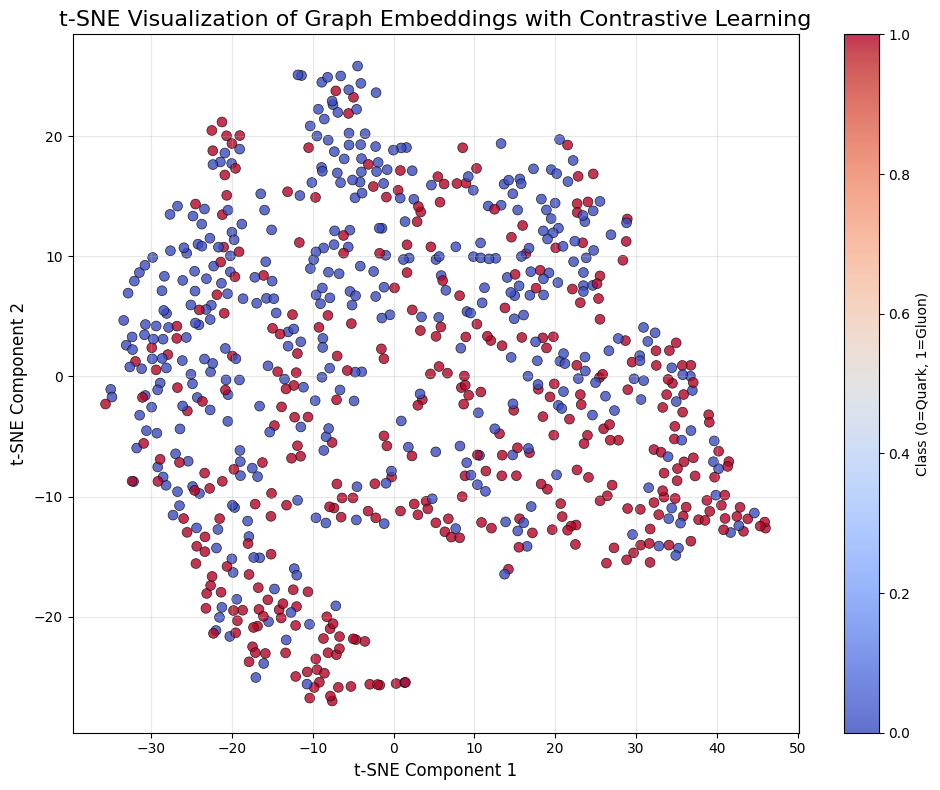

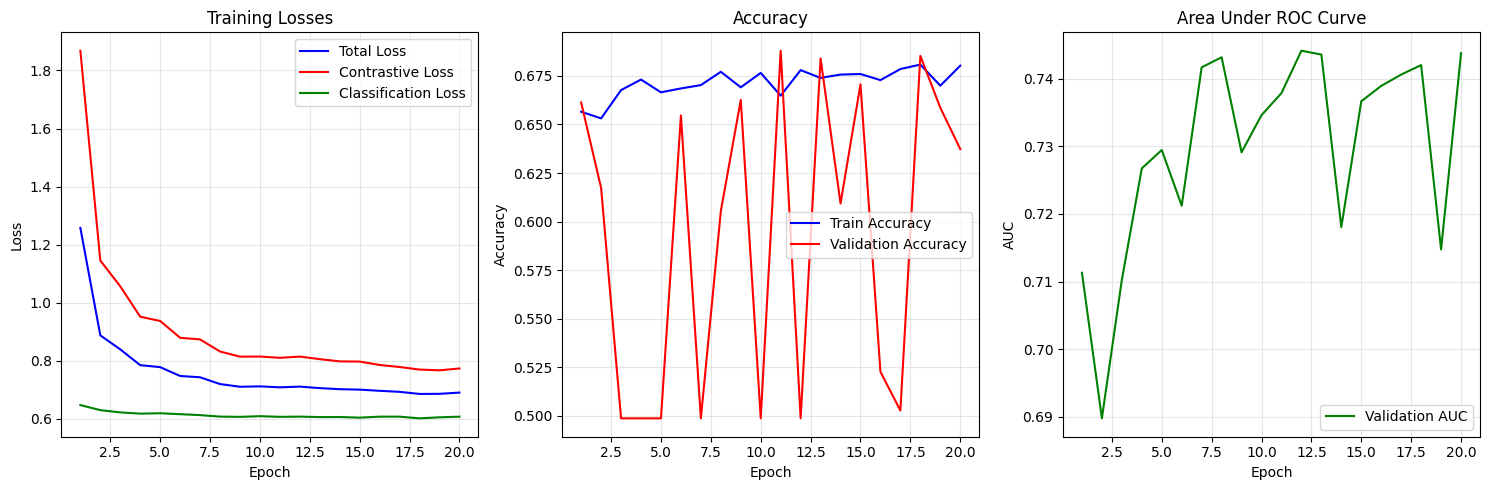


Running baseline classifier for comparison...

Training baseline model...


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.27it/s]
/opt/anaconda3/envs/PHYS2200/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20 | Train Loss: 0.6407 | Train Acc: 0.6469 | Val Acc: 0.5013 | Val AUC: 0.6692


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00, 10.12it/s]


Epoch 2/20 | Train Loss: 0.6139 | Train Acc: 0.6780 | Val Acc: 0.4987 | Val AUC: 0.7320


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00, 10.01it/s]


Epoch 3/20 | Train Loss: 0.6037 | Train Acc: 0.6843 | Val Acc: 0.4987 | Val AUC: 0.7448


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00, 10.29it/s]


Epoch 4/20 | Train Loss: 0.6002 | Train Acc: 0.6874 | Val Acc: 0.4987 | Val AUC: 0.7196


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00, 10.04it/s]


Epoch 5/20 | Train Loss: 0.6059 | Train Acc: 0.6786 | Val Acc: 0.4987 | Val AUC: 0.6963


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00, 10.03it/s]


Epoch 6/20 | Train Loss: 0.5993 | Train Acc: 0.6837 | Val Acc: 0.4987 | Val AUC: 0.7359


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.78it/s]


Epoch 7/20 | Train Loss: 0.5937 | Train Acc: 0.6860 | Val Acc: 0.6667 | Val AUC: 0.7290


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.96it/s]


Epoch 8/20 | Train Loss: 0.5948 | Train Acc: 0.6871 | Val Acc: 0.4987 | Val AUC: 0.7453


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.92it/s]


Epoch 9/20 | Train Loss: 0.5969 | Train Acc: 0.6857 | Val Acc: 0.5200 | Val AUC: 0.7477


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00, 10.01it/s]


Epoch 10/20 | Train Loss: 0.5935 | Train Acc: 0.6863 | Val Acc: 0.5080 | Val AUC: 0.7416


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.96it/s]


Epoch 11/20 | Train Loss: 0.5909 | Train Acc: 0.6937 | Val Acc: 0.4987 | Val AUC: 0.6687


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.94it/s]


Epoch 12/20 | Train Loss: 0.5911 | Train Acc: 0.6917 | Val Acc: 0.5320 | Val AUC: 0.7487


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00, 10.05it/s]


Epoch 13/20 | Train Loss: 0.5891 | Train Acc: 0.6903 | Val Acc: 0.5827 | Val AUC: 0.7508


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.85it/s]


Epoch 14/20 | Train Loss: 0.5871 | Train Acc: 0.6940 | Val Acc: 0.5347 | Val AUC: 0.7438


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.97it/s]


Epoch 15/20 | Train Loss: 0.5901 | Train Acc: 0.6909 | Val Acc: 0.6667 | Val AUC: 0.7533


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.97it/s]


Epoch 16/20 | Train Loss: 0.5885 | Train Acc: 0.6957 | Val Acc: 0.6187 | Val AUC: 0.7497


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00, 10.08it/s]


Epoch 17/20 | Train Loss: 0.5895 | Train Acc: 0.6883 | Val Acc: 0.5827 | Val AUC: 0.7477


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.34it/s]


Epoch 18/20 | Train Loss: 0.5918 | Train Acc: 0.6900 | Val Acc: 0.6373 | Val AUC: 0.7337


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.86it/s]


Epoch 19/20 | Train Loss: 0.5901 | Train Acc: 0.6934 | Val Acc: 0.6573 | Val AUC: 0.7215


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.67it/s]
/var/folders/04/kc22ss0n7_57lkh10y8qdkrr0000gn/T/ipykernel_56998/240946857.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

Epoch 20/20 | Train Loss: 0.5889 | Train Acc: 0.6957 | Val Acc: 0.6880 | Val AUC: 0.7528


Evaluating baseline: 100%|██████████████████████| 12/12 [00:01<00:00,  9.21it/s]



Model Comparison:
Metric          Contrastive     Baseline       
---------------------------------------------
Accuracy        0.6920           0.7147
Precision       0.6623           0.7210
Recall          0.7127           0.6479
F1              0.6866           0.6825
Auc             0.7572           0.7667


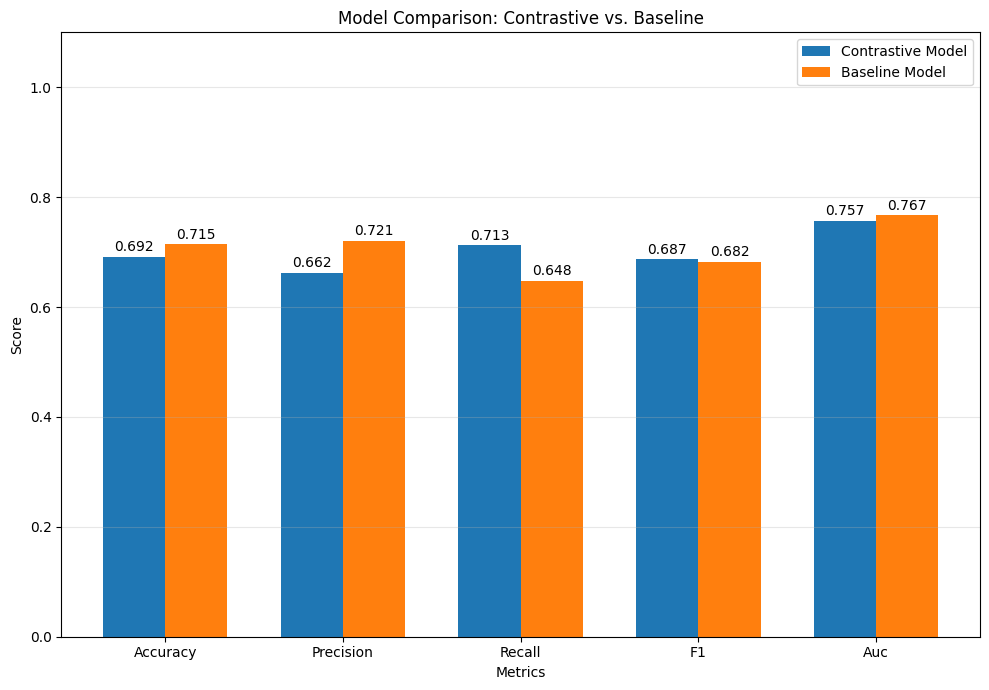

In [12]:
def main():
    # Load dataset
    X_jets, y = load_dataset()
    
    # Prepare datasets (using a smaller subset for faster processing)
    train_loader, val_loader, test_loader = prepare_datasets(X_jets, y, n_samples=5000)
    
    # Initialize model
    in_channels = 3  # ECAL, HCAL, Tracks
    hidden_channels = 64
    embedding_dim = 128
    projection_dim = 64
    
    model = GraphContrastiveModel(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        embedding_dim=embedding_dim,
        projection_dim=projection_dim
    ).to(device)
    
    print(model)
    
    # Train the model
    model, train_losses, val_metrics = train_model(
        model, train_loader, val_loader, device, 
        epochs=20, lr=0.001, weight_decay=1e-5
    )
    
    # Evaluate on test set
    test_results = evaluate(model, test_loader, device)
    print("\nTest Results:")
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    print(f"Precision: {test_results['precision']:.4f}")
    print(f"Recall: {test_results['recall']:.4f}")
    print(f"F1 Score: {test_results['f1']:.4f}")
    print(f"AUC: {test_results['auc']:.4f}")
    
    # Visualize embeddings
    embeddings_2d, labels = visualize_embeddings(model, test_loader, device)
    
    # Plot training curves
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 3, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, [x[0] for x in train_losses], 'b-', label='Total Loss')
    plt.plot(epochs, [x[1] for x in train_losses], 'r-', label='Contrastive Loss')
    plt.plot(epochs, [x[2] for x in train_losses], 'g-', label='Classification Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, [x[3] for x in train_losses], 'b-', label='Train Accuracy')
    plt.plot(epochs, [x['accuracy'] for x in val_metrics], 'r-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # AUC plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, [x['auc'] for x in val_metrics], 'g-', label='Validation AUC')
    plt.title('Area Under ROC Curve')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300)
    plt.show()
    
    # Compare with non-contrastive model
    print("\nRunning baseline classifier for comparison...")
    
    # Define a simpler GNN model without contrastive learning
    class BaselineGNN(nn.Module):
        def __init__(self, in_channels, hidden_channels):
            super(BaselineGNN, self).__init__()
            self.conv1 = GCNConv(in_channels, hidden_channels)
            self.conv2 = GCNConv(hidden_channels, hidden_channels)
            self.conv3 = GCNConv(hidden_channels, hidden_channels)
            self.classifier = nn.Linear(hidden_channels, 2)
            self.bn1 = nn.BatchNorm1d(hidden_channels)
            self.bn2 = nn.BatchNorm1d(hidden_channels)
            
        def forward(self, x, edge_index, batch):
            x = self.conv1(x, edge_index)
            x = self.bn1(x)
            x = F.relu(x)
            
            x = self.conv2(x, edge_index)
            x = self.bn2(x)
            x = F.relu(x)
            
            x = self.conv3(x, edge_index)
            x = global_mean_pool(x, batch)
            
            return self.classifier(x)
    
    # Train baseline model
    baseline_model = BaselineGNN(in_channels=3, hidden_channels=64).to(device)
    
    # Define training function for baseline
    def train_baseline(model, loader, optimizer, device):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        criterion = nn.CrossEntropyLoss()
        
        for data in tqdm(loader, desc="Training baseline"):
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data.x, data.edge_index, data.batch)
            
            # Compute loss
            loss = criterion(out, data.y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track metrics
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.y.size(0)
        
        return total_loss / total, correct / total
    
    # Evaluate baseline model
    def evaluate_baseline(model, loader, device):
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for data in tqdm(loader, desc="Evaluating baseline"):
                data = data.to(device)
                
                # Forward pass
                out = model(data.x, data.edge_index, data.batch)
                
                # Calculate predictions
                pred = out.argmax(dim=1)
                correct += int((pred == data.y).sum())
                total += data.y.size(0)
                
                # Store predictions and labels for metrics
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(data.y.cpu().numpy())
                all_probs.extend(F.softmax(out, dim=1)[:, 1].cpu().numpy())
        
        # Calculate metrics
        accuracy = correct / total
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        auc = roc_auc_score(all_labels, all_probs)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
    
    # Train the baseline model
    baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001, weight_decay=1e-5)
    baseline_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        baseline_optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-6
    )
    
    best_baseline_val_acc = 0
    baseline_train_losses = []
    baseline_train_accs = []
    baseline_val_metrics = []
    
    print("\nTraining baseline model...")
    
    for epoch in range(1, 21):  # Same number of epochs as contrastive model
        # Train
        train_loss, train_acc = train_baseline(baseline_model, train_loader, baseline_optimizer, device)
        
        # Validate
        val_results = evaluate_baseline(baseline_model, val_loader, device)
        val_acc = val_results['accuracy']
        
        # Update learning rate
        baseline_scheduler.step(val_acc)
        
        # Save model if validation accuracy improves
        if val_acc > best_baseline_val_acc:
            best_baseline_val_acc = val_acc
            torch.save(baseline_model.state_dict(), 'best_baseline_model.pt')
        
        # Track metrics
        baseline_train_losses.append(train_loss)
        baseline_train_accs.append(train_acc)
        baseline_val_metrics.append(val_results)
        
        # Print progress
        print(f"Epoch {epoch}/20 | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f} | "
              f"Val AUC: {val_results['auc']:.4f}")
    
    # Load best baseline model
    baseline_model.load_state_dict(torch.load('best_baseline_model.pt'))
    
    # Evaluate baseline on test set
    baseline_test_results = evaluate_baseline(baseline_model, test_loader, device)
    
    # Compare results
    print("\nModel Comparison:")
    print(f"{'Metric':<15} {'Contrastive':<15} {'Baseline':<15}")
    print(f"{'-'*45}")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
        print(f"{metric.capitalize():<15} {test_results[metric]:.4f}{' '*10} {baseline_test_results[metric]:.4f}")

    # Plot comparison
    plt.figure(figsize=(10, 7))
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    x = np.arange(len(metrics))
    width = 0.35
    
    contrastive_values = [test_results[m] for m in metrics]
    baseline_values = [baseline_test_results[m] for m in metrics]
    
    plt.bar(x - width/2, contrastive_values, width, label='Contrastive Model')
    plt.bar(x + width/2, baseline_values, width, label='Baseline Model')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Comparison: Contrastive vs. Baseline')
    plt.xticks(x, [m.capitalize() for m in metrics])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(contrastive_values):
        plt.text(i - width/2, v + 0.01, f"{v:.3f}", ha='center')
    
    for i, v in enumerate(baseline_values):
        plt.text(i + width/2, v + 0.01, f"{v:.3f}", ha='center')
    
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()